In [1]:
# LOADING REQUIRED PACKAGES
import pickle
from collections import Counter
import itertools
import json
import powerlaw
from kneed import KneeLocator
import pickle

# NetworkX and Seaborn
from networkx.algorithms import bipartite
import seaborn as sns
from collections import defaultdict

# === Third-Party Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Patch

import matplotlib.ticker as ticker 

from adjustText import adjust_text
import networkx as nx
from networkx.algorithms import bipartite
import community as community_louvain  # Louvain community detection (python-louvain)
import textwrap
# Optional: Configure matplotlib to use a specific style or suppress warnings
# plt.style.use('seaborn-whitegrid')  # optional, if you want a consistent style

# !pip install ipycytoscape ipywidgets

import io, base64, math, textwrap
import ipycytoscape
import matplotlib
from IPython.display import display

In [2]:
# LOADING THE UNIPARTITE DISEASE _species PROJECTION NETWORK
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/network_analysis/bipartite_species_network.gpickle", "rb") as f:
    B_species = pickle.load(f)

In [3]:
# Open the JSON file containing disease name mappings
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/taxon_dict.json", "r") as f:
    taxon_dict = json.load(f)

# Load the phenotype mapping JSON
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/taxon_phyla_dict.json", "r") as f:
    taxon_category_by_id = json.load(f)


=== Network Summary ===
Number of nodes: 1144
Number of edges: 199073
Degree range: (28.0, 978.0)
Edge weight range: (1.0, 23.0)


/tmp/ipykernel_4082268/1668128901.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("inferno")


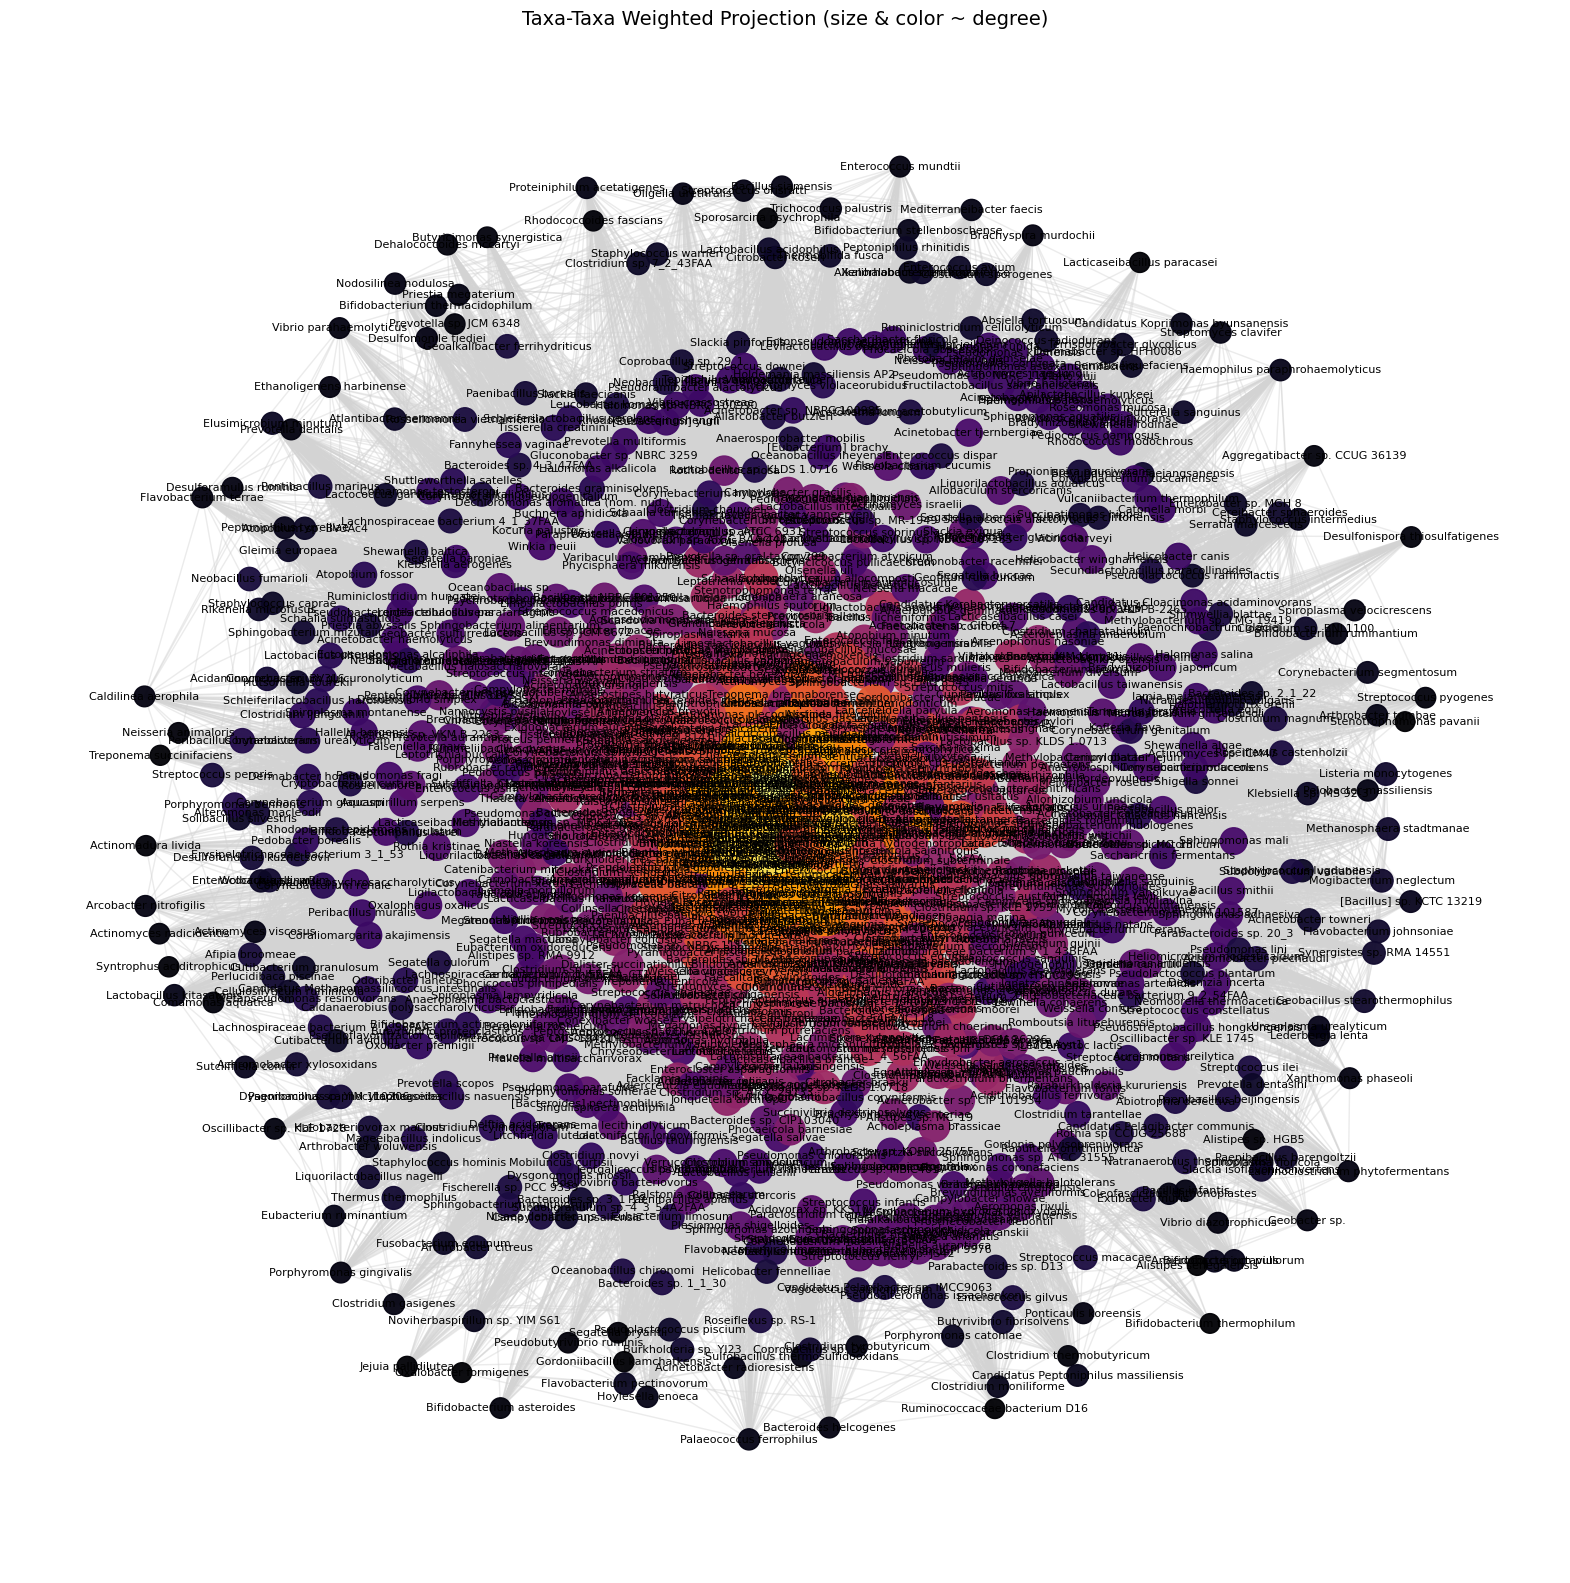

In [4]:
# BIPARTITE DISEASE DIEASE NETWORK
# --- Partitions from B_species (assumes bipartite attr: 0=diseases, 1=taxa) ---
taxa = {n for n, d in B_species.nodes(data=True) if d.get("bipartite") == 1}
if not taxa:
    raise ValueError("No taxa nodes found with bipartite==1 in B_species.")

# --- Weighted unipartite projection: disease–disease (weight = shared taxa count) ---
G = bipartite.weighted_projected_graph(B_species, taxa)

# === Summary stats ===
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
deg_vals = np.array([deg for _, deg in G.degree()], dtype=float)
weights = np.array([d.get("weight", 1.0) for _, _, d in G.edges(data=True)], dtype=float)

summary = {
    "Number of nodes": num_nodes,
    "Number of edges": num_edges,
    "Degree range": (deg_vals.min() if deg_vals.size else None,
                     deg_vals.max() if deg_vals.size else None),
    "Edge weight range": (weights.min() if weights.size else None,
                          weights.max() if weights.size else None)
}
print("=== Network Summary ===")
for k, v in summary.items():
    if isinstance(v, tuple):
        v = tuple(float(x) if x is not None else None for x in v)
    print(f"{k}: {v}")

# --- Layout ---
pos = nx.spring_layout(G, seed=42, k=1.2)

# --- Node sizes: normalize degree to [0,1] then map to pixel range ---
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)

min_size, max_size = 200, 1000
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Node colors: same normalization → Inferno colormap ---
cmap = cm.get_cmap("inferno")
node_colors = cmap(deg_norm)  # RGBA colors aligned with node order below

# --- Edge widths: normalize weights to [0,1] then map to pixel range ---
if weights.size:
    wmin, wmax = weights.min(), weights.max()
    w_norm = (weights - wmin) / (wmax - wmin) if wmax != wmin else np.ones_like(weights)
    edge_widths = 1.0 + 4.0 * w_norm
else:
    edge_widths = []

# --- Labels from disease_dict (fallback to code if missing) ---
labels = {n: taxon_dict.get(n, str(n)) for n in G.nodes()}

# --- Draw ---
plt.figure(figsize=(20, 20))

# Edges first
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.45, edge_color="lightgray")

# Nodes
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=list(G.nodes()),
    node_size=node_sizes,
    node_color=node_colors,
    alpha=0.95,
)

# Labels
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

plt.title("Taxa-Taxa Weighted Projection (size & color ~ degree)", fontsize=14)
plt.axis("off")
plt.show()


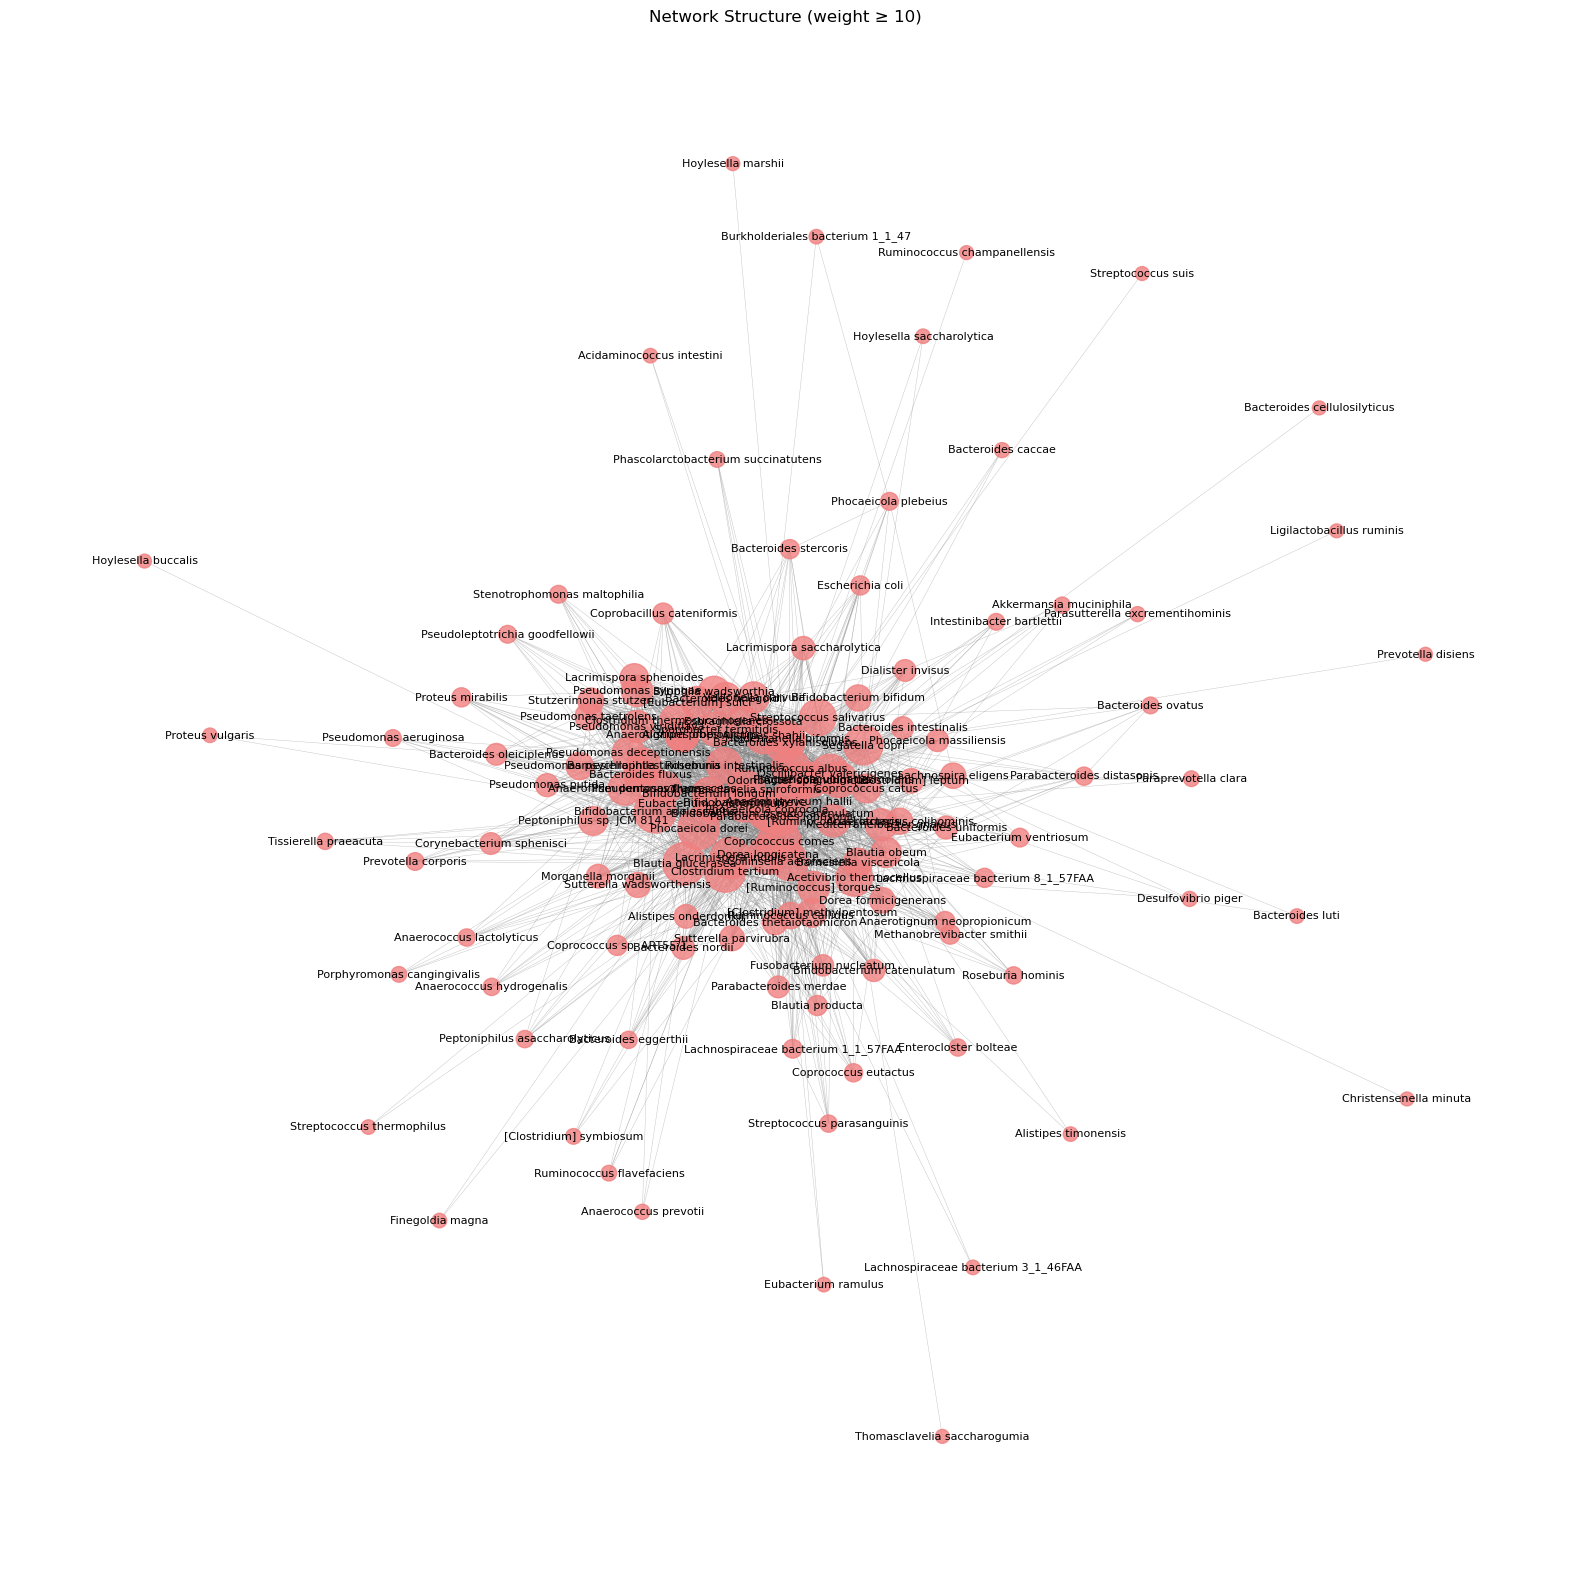

In [5]:
# === User-defined threshold ===
edge_weight_threshold = 10 # change this to your cutoff

# === Step 1: Apply edge weight filtering ===
if edge_weight_threshold > 0:
    G_filtered = nx.Graph()
    for u, v, data in G.edges(data=True):
        weight = data.get("weight", 1)  # default weight = 1 if not present
        if weight >= edge_weight_threshold:
            G_filtered.add_edge(u, v, **data)
else:
    G_filtered = G.copy()

# If you don't already have pos from a previous cell, compute it here:
pos = nx.spring_layout(G_filtered, seed=42)

# Map node IDs to readable labels from taxon_dict
labels = {n: taxon_dict.get(n, str(n)) for n in G_filtered.nodes()}

# --- Node sizes: normalize degree to [0,1] then map to pixel range ---
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)

min_size, max_size = 100, 1000
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Plot ---
plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(G_filtered, pos, node_size=node_sizes, node_color='lightcoral', alpha=0.8)
nx.draw_networkx_edges(G_filtered, pos, width=0.3, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_filtered, pos, labels=labels, font_size=8)

plt.title(f"Network Structure (weight ≥ {edge_weight_threshold})")
plt.axis('off')
plt.show()


/tmp/ipykernel_4082268/1805678467.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", max(len(used_categories), 1))
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


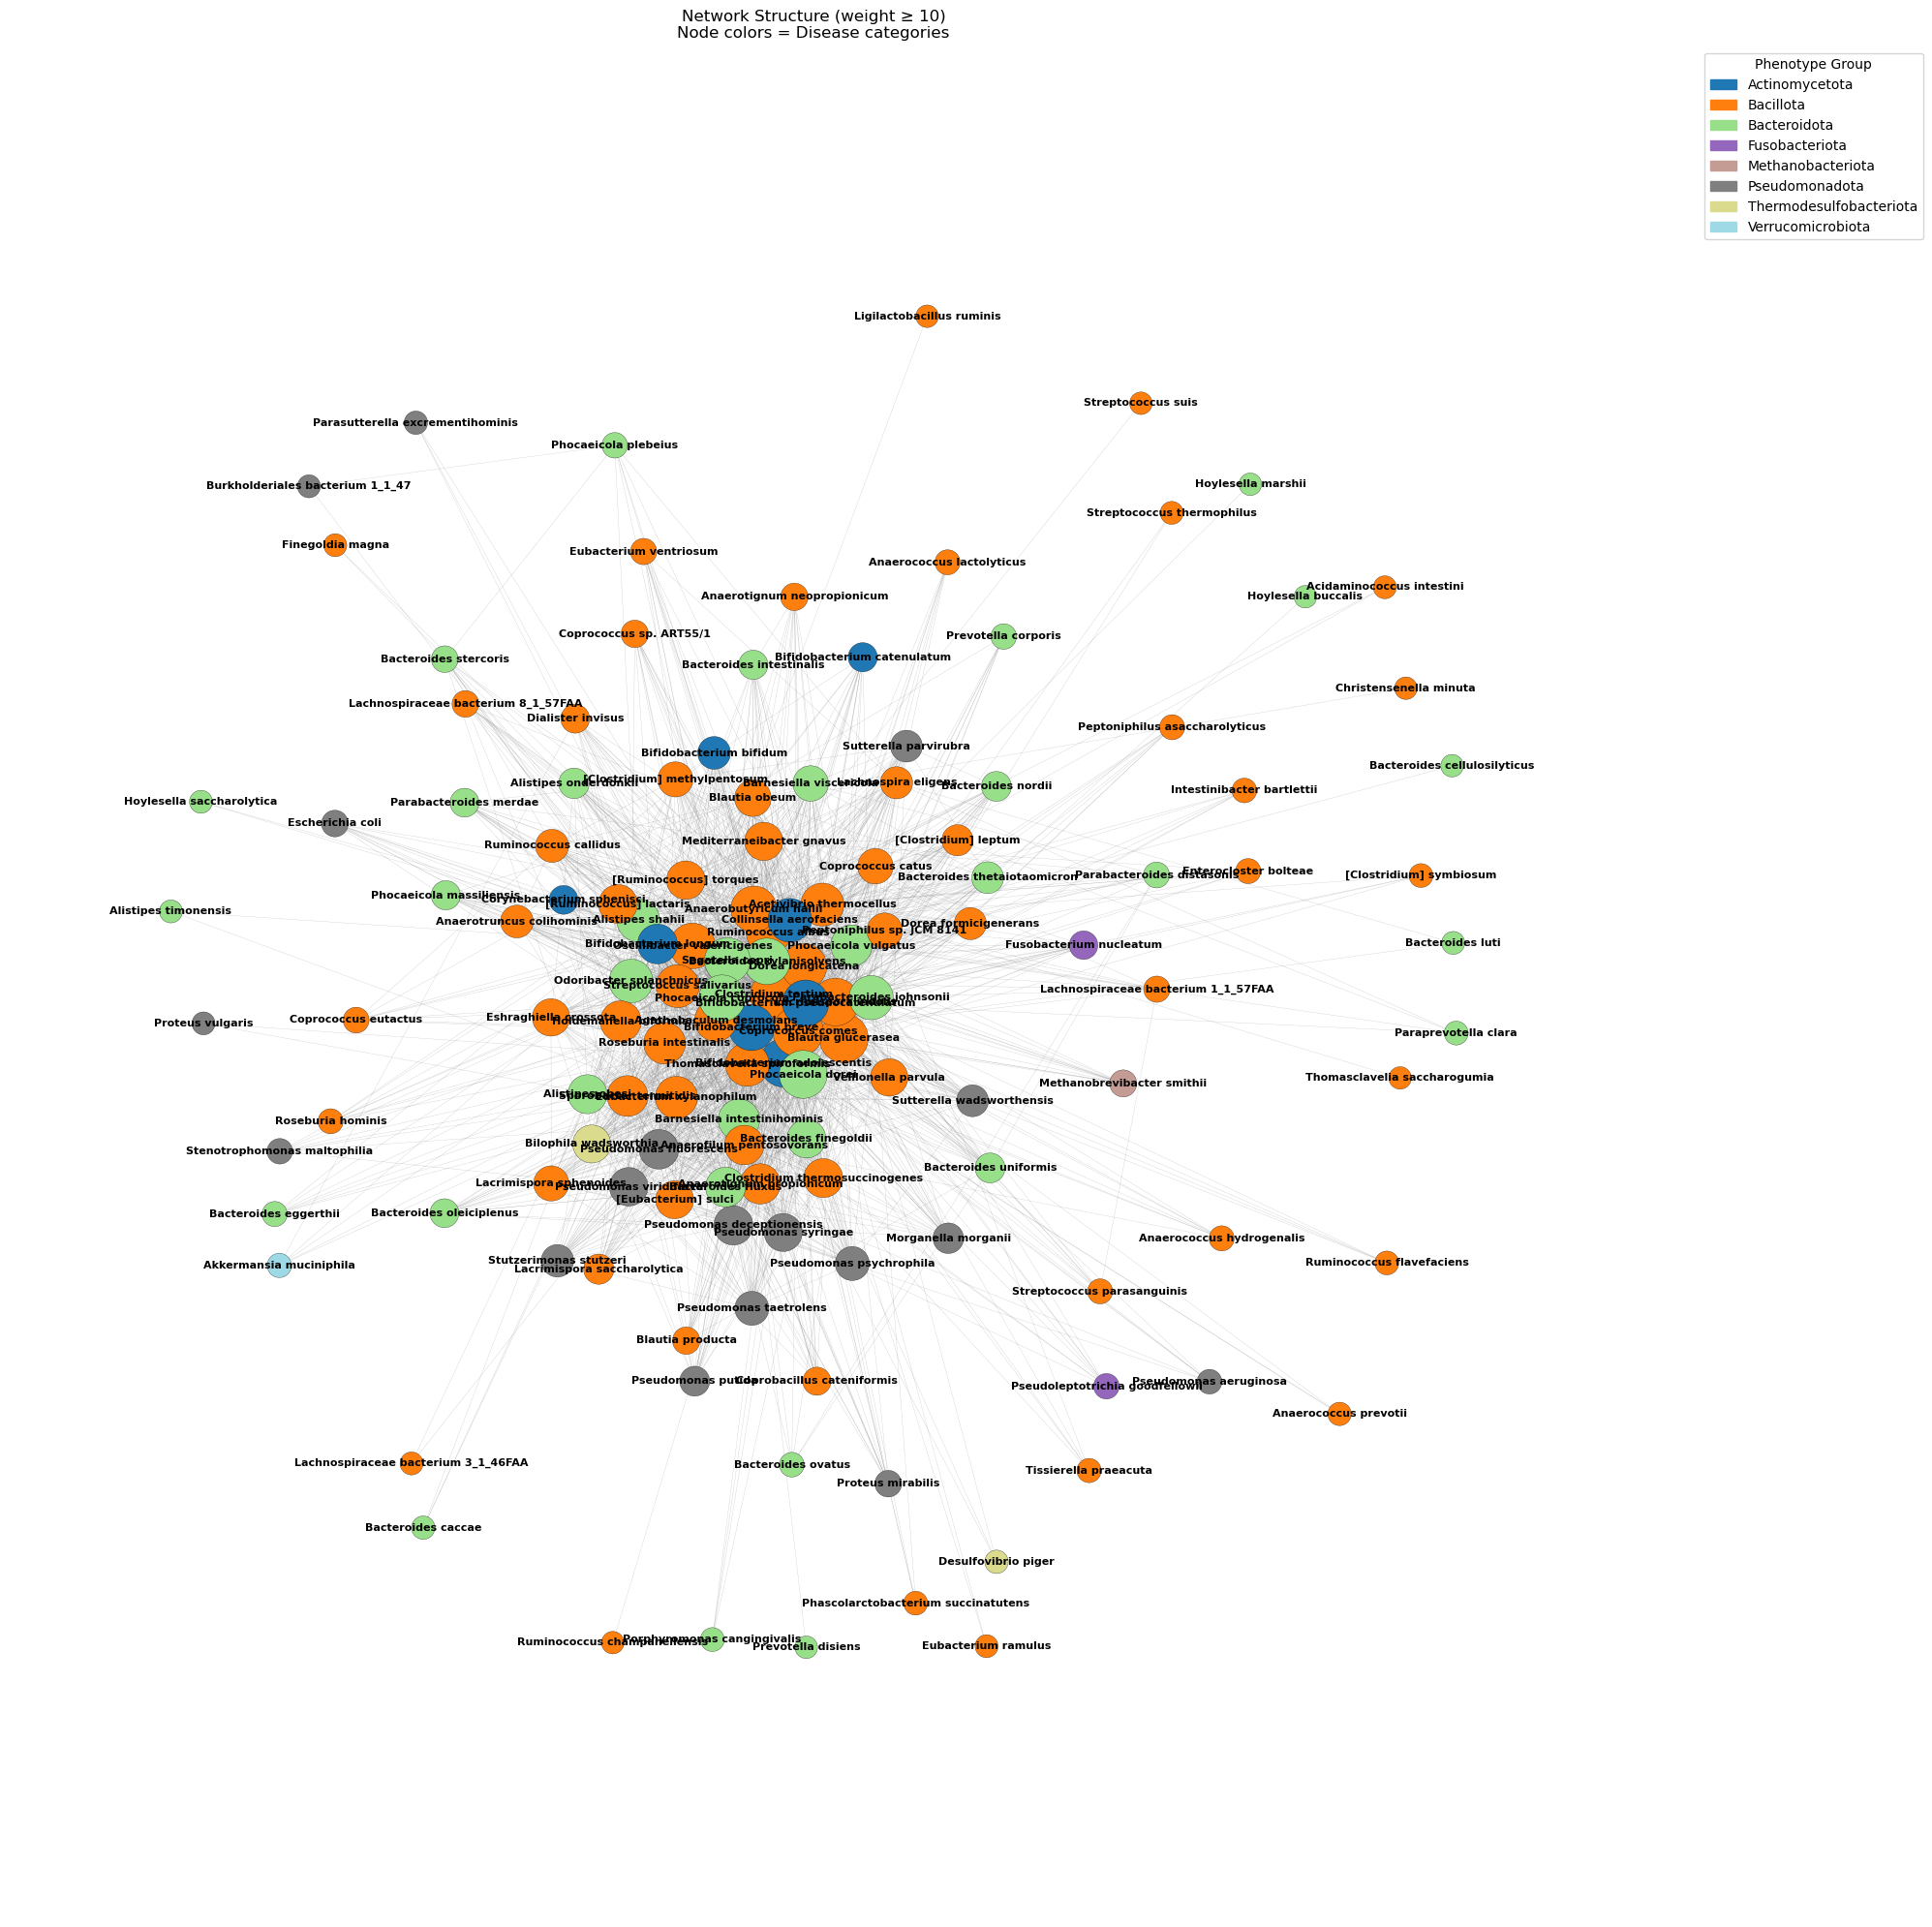

In [6]:

# Ensure all node IDs are strings to match dictionary keys
G_filtered = nx.relabel_nodes(G_filtered, {n: str(n) for n in G_filtered.nodes()})
taxon_category_by_id = {str(k): ([str(c) for c in v] if isinstance(v, list) else [str(v)])
                        for k, v in taxon_category_by_id.items()}

# --- Layout & labels ---
pos = nx.spring_layout(G_filtered, seed=42, k=2)

# Scale the layout outward without recalculating
scale_factor = 4.0
pos = {n: (x * scale_factor, y * scale_factor) for n, (x, y) in pos.items()}

labels = {n: taxon_dict.get(n, str(n)) for n in G_filtered.nodes()}

# --- Node size from degree ---
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
min_size, max_size = 200, 1000
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Normalize categories per node ---
node_cats = {}
for n in G_filtered.nodes():
    cats = taxon_category_by_id.get(n, [])
    if not cats or not isinstance(cats, list):
        cats = ["(Unclassified)"]
    cats = [str(c).strip() if c else "(Unclassified)" for c in cats]
    node_cats[n] = cats

# --- Used categories ---
used_categories = sorted({c for cats in node_cats.values() for c in cats})

# --- Color map for categories ---
cmap = plt.cm.get_cmap("tab20", max(len(used_categories), 1))
category_colors = {cat: cmap(i) for i, cat in enumerate(used_categories)}

# --- Figure & axis ---
fig, ax = plt.subplots(figsize=(20, 20))

# Draw edges
nx.draw_networkx_edges(G_filtered, pos, width=0.2, alpha=0.5, ax=ax, edge_color="gray")

# Axis limits from positions
xs = np.array([p[0] for p in pos.values()])
ys = np.array([p[1] for p in pos.values()])
pad_x = (xs.max() - xs.min()) * 0.10
pad_y = (ys.max() - ys.min()) * 0.10
ax.set_xlim(xs.min() - pad_x, xs.max() + pad_x)
ax.set_ylim(ys.min() - pad_y, ys.max() + pad_y)
ax.set_aspect('equal', adjustable='datalim')

# Convert node size to radius in data coords
def points2data_radius(ax, size_pts2):
    r_pts = np.sqrt(size_pts2 / np.pi)          # points
    r_px = r_pts * (fig.dpi / 72.0)             # pixels
    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    dx_per_px = (x1 - x0) / ax.bbox.width
    dy_per_px = (y1 - y0) / ax.bbox.height
    return r_px * 0.5 * (dx_per_px + dy_per_px)

# Draw nodes as pie slices
for size, n in zip(node_sizes, G_filtered.nodes()):
    cats = node_cats[n]
    r = points2data_radius(ax, size)
    x, y = pos[n]
    k = len(cats)
    for j, cat in enumerate(cats):
        theta1 = 360.0 * j / k
        theta2 = 360.0 * (j + 1) / k
        wedge = mpatches.Wedge(
            (x, y), r, theta1, theta2,
            facecolor=category_colors.get(cat, "lightgray"),
            edgecolor="black", lw=0.2, zorder=2
        )
        ax.add_patch(wedge)

# Labels
nx.draw_networkx_labels(G_filtered, pos, labels=labels, font_size=8, ax=ax, font_weight='bold')

# Title
ax.set_title(f"Network Structure (weight ≥ {edge_weight_threshold})\nNode colors = Disease categories")
ax.axis('off')

# Legend
legend_handles = [mpatches.Patch(color=category_colors[c], label=c) for c in used_categories]
ax.legend(handles=legend_handles, title="Phenotype Group", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [19]:
# !pip install ipycytoscape ipywidgets

import io, base64, math, textwrap
import ipycytoscape
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from IPython.display import display

# ===================== Tunables =====================
wrap_width          = 11
PX_MIN, PX_MAX      = 700, 2100          # tiny nodes
EDGE_W_MIN, EDGE_W_MAX = 5, 30   # thin edges
LABEL_LIMIT         = 140             # only hubs get labels (others on click)
FONT_PX             = 550

# Stretch controls (center expansion)
MAX_EXTRA_SCALE     = 3.5
INFLUENCE_RAD       = 0.85
BASE_SPACING        = 6000.0

WIDGET_W, WIDGET_H  = '2000px', '1200px'

# ===================== Inputs / fallbacks =====================
# labels / pos may already exist from your previous cell
if 'labels' not in globals():
    labels = {n: (taxon_dict.get(n, str(n)) if 'taxon_dict' in globals() else str(n))
              for n in G_filtered.nodes()}
if 'pos' not in globals():
    pos = nx.spring_layout(G_filtered, seed=42, iterations=1000)

def get_cats(n):
    if 'taxon_category_by_id' in globals():
        cs = taxon_category_by_id.get(n, [])
        return cs if isinstance(cs, list) and cs else ["(Unclassified)"]
    return ["(Unclassified)"]

node_cats = {n: get_cats(n) for n in G_filtered.nodes()}

# ===================== Category palette =====================
# Step 1: define the first four categories in your chosen order
priority_categories = [
    "Actinomycetota",
    "Pseudomonadota",
    "Bacillota",
    "Bacteroidota"
]

# Step 2: grab any other categories present in the graph (excluding the four above)
all_categories = {cat for cs in node_cats.values() for cat in cs}
remaining_categories = [c for c in all_categories if c not in priority_categories]

# Step 3: build the final ordered list (priority first, then the rest)
used_categories = priority_categories + remaining_categories
num_cats = len(used_categories)

# Step 4: assign colors from Set2 in this fixed order
try:
    cmap = matplotlib.colormaps.get_cmap("Set3").resampled(num_cats)
except Exception:
    cmap = plt.cm.get_cmap("Set3", num_cats)

def rgba_to_hex(rgba):
    if isinstance(rgba, str):
        return rgba
    r, g, b, a = rgba[:4]
    return f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"

category_colors = {cat: rgba_to_hex(cmap(i)) for i, cat in enumerate(used_categories)}




# ===================== Tiny solid PNG per category (cached) =====================
def solid_png_b64(hexcol, size_px=8):
    fig = plt.figure(figsize=(size_px/96, size_px/96), dpi=96)
    fig.patch.set_alpha(0)
    ax = plt.axes([0, 0, 1, 1]); ax.set_axis_off(); ax.patch.set_alpha(0)
    ax.add_patch(plt.Circle((0.5, 0.5), 0.5, color=hexcol))
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=96, transparent=True)
    plt.close(fig)
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("ascii")

img_by_cat = {cat: solid_png_b64(color, size_px=8) for cat, color in category_colors.items()}

# ===================== Degree → node size =====================
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0: raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm   = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
deg_by_node = dict(zip([n for n, _ in G_filtered.degree()], deg_vals))

def size_unit_to_px(u):
    return int(PX_MIN + float(u) * (PX_MAX - PX_MIN))

# ===================== Edge width & colour =====================
def edge_color(u, v):
    cu = node_cats[u][0]; cv = node_cats[v][0]
    return category_colors.get(cu, "#bfbfbf") if cu == cv else "#cfcfcf"

weights = [G_filtered[u][v].get("weight", 1.0) for u, v in G_filtered.edges()]
if weights:
    w_min, w_max = float(min(weights)), float(max(weights))
    log_min, log_max = math.log(w_min + 1.0), math.log(w_max + 1.0)
    def edge_w_px(w):
        if log_max > log_min:
            val = (math.log(w + 1.0)**2 - log_min**2) / (log_max**2 - log_min**2)
            val = max(0.0, min(1.0, val))
        else:
            val = 0.0
        return EDGE_W_MIN + val * (EDGE_W_MAX - EDGE_W_MIN)
else:
    def edge_w_px(w): return EDGE_W_MIN

# ===================== Center-expansion (stretched preset) =====================
xs = [p[0] for p in pos.values()]; ys = [p[1] for p in pos.values()]
cx, cy = (max(xs)+min(xs))/2.0, (max(ys)+min(ys))/2.0
max_dist = max(((x-cx)**2 + (y-cy)**2)**0.5 for (x, y) in pos.values()) or 1.0

pos_adjusted = {}
for n, (x, y) in pos.items():
    dx, dy = x - cx, y - cy
    dist   = (dx*dx + dy*dy)**0.5
    nd     = dist / max_dist
    if nd < INFLUENCE_RAD:
        scale = MAX_EXTRA_SCALE - (MAX_EXTRA_SCALE - 1.0) * (nd / INFLUENCE_RAD)
    else:
        scale = 1.0
    pos_adjusted[n] = (cx + dx * scale * BASE_SPACING,
                       cy + dy * scale * BASE_SPACING)

# ===================== Labels (only hubs get text) =====================
if LABEL_LIMIT and len(G_filtered) > LABEL_LIMIT:
    hubs = {n for n, _ in sorted(deg_by_node.items(), key=lambda kv: kv[1], reverse=True)[:LABEL_LIMIT]}
else:
    hubs = set(G_filtered.nodes())

def wrap_label(n):
    s = labels.get(n, str(n))
    return "\n".join(textwrap.wrap(s, width=wrap_width, break_long_words=False, break_on_hyphens=False))

# ===================== Build ONE JSON payload =====================
nodes_json, edges_json = [], []
for n in G_filtered.nodes():
    cat  = node_cats[n][0]
    size = size_unit_to_px(deg_norm[list(G_filtered.nodes()).index(n)])
    label = wrap_label(n) if n in hubs else ""  # shrink payload
    x, y  = pos_adjusted[n]
    nodes_json.append({
        "data": {
            "id": str(n),
            "label": label,
            "category": cat,
            "w": float(size),
            "h": float(size)
        },
        "position": {"x": float(x), "y": float(y)}
    })

for u, v, d in G_filtered.edges(data=True):
    w = float(d.get("weight", 1.0))
    edges_json.append({
        "data": {
            "source": str(u),
            "target": str(v),
            "color": edge_color(u, v),
            "w": float(edge_w_px(w))
        }
    })

elements = {"nodes": nodes_json, "edges": edges_json}

# ===================== Widget (single add) =====================
cyto = ipycytoscape.CytoscapeWidget()
cyto.layout.width  = WIDGET_W
cyto.layout.height = WIDGET_H
cyto.graph.add_graph_from_json(elements)  # ONE message instead of thousands

# ===================== Styles =====================
base_styles = [
    {
        'selector': 'node',
        'style': {
            'shape': 'ellipse',
            'width':  'data(w)',
            'height': 'data(h)',
            'background-color': '#000',        # hidden by image
            'background-opacity': 0.4,
            'label': 'data(label)',
            'font-size': f'{FONT_PX}px',
            'color': '#000',
            'text-wrap': 'wrap',
            'text-max-width': '120px',
            'text-valign': 'bottom',
            'text-halign': 'right',
            'text-margin-x': -6,
            'text-margin-y': 5,
            'border-width': 0,
            'overlay-opacity': 0
        }
    },
    {
        'selector': 'edge',
        'style': {
            'line-color': 'data(color)',
            'width': 'data(w)',
            'opacity': 0.8,
            'curve-style': 'haystack',   # faster & less cluttered than bezier
            'haystack-radius': 0.4
        }
    },
    {
        'selector': 'node:selected',
        'style': {'font-size': f'{FONT_PX+200}px'}
    }
]

# category-specific background images (cached once)
cat_img_styles = [
    {
        'selector': f'node[category = "{cat}"]',
        'style': {
            'background-image': f'url({img_by_cat[cat]})',
            'background-image-opacity': 0.6,
            'background-fit': 'cover'
        }
    } for cat in used_categories
]

cyto.set_style(base_styles + cat_img_styles)

# Preset stretched layout
cyto.set_layout(name='preset')
display(cyto)


# ===================== Legend =====================
from IPython.display import display, HTML  # ✅ add HTML here
legend_bits = []
for cat in used_categories:
    hexcol = category_colors[cat]
    legend_bits.append(
        f'<div style="display:flex;align-items:center;margin:2px 0;">'
        f'  <span style="display:inline-block;width:14px;height:14px;background:{hexcol};'
        f'         border:1px solid #000;margin-right:8px;"></span>'
        f'  <span style="font-size:14px;line-height:1.1;color:#000;">{cat}</span>'
        f'</div>'
    )

legend_html = (
    "<div style='margin-top:10px;display:inline-block;border:1px solid #ddd;"
    "padding:8px 10px;border-radius:6px;background:#fff;'>"
    "<div style='font-weight:600;margin-bottom:6px;color:#000;'>Taxon Classification - Phylum</div>"
    + "".join(legend_bits) +
    "</div>"
)
display(HTML(legend_html))

CytoscapeWidget(cytoscape_layout={'name': 'preset'}, cytoscape_style=[{'selector': 'node', 'style': {'shape': …

In [29]:
# !pip install ipycytoscape ipywidgets

import io, base64, math, textwrap
import ipycytoscape
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from IPython.display import display

# ===================== Tunables =====================
wrap_width          = 11
PX_MIN, PX_MAX      = 700, 2100          # tiny nodes
EDGE_W_MIN, EDGE_W_MAX = 5, 30   # thin edges
LABEL_LIMIT         = 140             # only hubs get labels (others on click)
FONT_PX             = 550

# Stretch controls (center expansion)
MAX_EXTRA_SCALE     = 3.5
INFLUENCE_RAD       = 0.85
BASE_SPACING        = 6000.0

WIDGET_W, WIDGET_H  = '2000px', '1200px'

# ===================== Inputs / fallbacks =====================
# labels / pos may already exist from your previous cell
if 'labels' not in globals():
    labels = {n: (taxon_dict.get(n, str(n)) if 'taxon_dict' in globals() else str(n))
              for n in G_filtered.nodes()}
if 'pos' not in globals():
    pos = nx.spring_layout(G_filtered, seed=42, iterations=1000)

def get_cats(n):
    if 'taxon_category_by_id' in globals():
        cs = taxon_category_by_id.get(n, [])
        return cs if isinstance(cs, list) and cs else ["(Unclassified)"]
    return ["(Unclassified)"]

node_cats = {n: get_cats(n) for n in G_filtered.nodes()}



# Step 2: grab any other categories present in the graph (excluding the four above)
all_categories = {cat for cs in node_cats.values() for cat in cs}
remaining_categories = [c for c in all_categories if c not in priority_categories]

# Step 3: build the final ordered list (priority first, then the rest)
used_categories = priority_categories + remaining_categories
num_cats = len(used_categories)

# Step 4: assign colors from Set2 in this fixed order
try:
    cmap = matplotlib.colormaps.get_cmap("tab20b").resampled(num_cats)
except Exception:
    cmap = plt.cm.get_cmap("tab20b", num_cats)

def rgba_to_hex(rgba):
    if isinstance(rgba, str):
        return rgba
    r, g, b, a = rgba[:4]
    return f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"

category_colors = {cat: rgba_to_hex(cmap(i)) for i, cat in enumerate(used_categories)}




# ===================== Tiny solid PNG per category (cached) =====================
def solid_png_b64(hexcol, size_px=8):
    fig = plt.figure(figsize=(size_px/96, size_px/96), dpi=96)
    fig.patch.set_alpha(0)
    ax = plt.axes([0, 0, 1, 1]); ax.set_axis_off(); ax.patch.set_alpha(0)
    ax.add_patch(plt.Circle((0.5, 0.5), 0.5, color=hexcol))
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=96, transparent=True)
    plt.close(fig)
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("ascii")

img_by_cat = {cat: solid_png_b64(color, size_px=8) for cat, color in category_colors.items()}

# ===================== Degree → node size =====================
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0: raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm   = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
deg_by_node = dict(zip([n for n, _ in G_filtered.degree()], deg_vals))

def size_unit_to_px(u):
    return int(PX_MIN + float(u) * (PX_MAX - PX_MIN))

# ===================== Edge width & colour =====================
def edge_color(u, v):
    cu = node_cats[u][0]; cv = node_cats[v][0]
    return category_colors.get(cu, "#bfbfbf") if cu == cv else "#cfcfcf"

weights = [G_filtered[u][v].get("weight", 1.0) for u, v in G_filtered.edges()]
if weights:
    w_min, w_max = float(min(weights)), float(max(weights))
    log_min, log_max = math.log(w_min + 1.0), math.log(w_max + 1.0)
    def edge_w_px(w):
        if log_max > log_min:
            val = (math.log(w + 1.0)**2 - log_min**2) / (log_max**2 - log_min**2)
            val = max(0.0, min(1.0, val))
        else:
            val = 0.0
        return EDGE_W_MIN + val * (EDGE_W_MAX - EDGE_W_MIN)
else:
    def edge_w_px(w): return EDGE_W_MIN

# ===================== Center-expansion (stretched preset) =====================
xs = [p[0] for p in pos.values()]; ys = [p[1] for p in pos.values()]
cx, cy = (max(xs)+min(xs))/2.0, (max(ys)+min(ys))/2.0
max_dist = max(((x-cx)**2 + (y-cy)**2)**0.5 for (x, y) in pos.values()) or 1.0

pos_adjusted = {}
for n, (x, y) in pos.items():
    dx, dy = x - cx, y - cy
    dist   = (dx*dx + dy*dy)**0.5
    nd     = dist / max_dist
    if nd < INFLUENCE_RAD:
        scale = MAX_EXTRA_SCALE - (MAX_EXTRA_SCALE - 1.0) * (nd / INFLUENCE_RAD)
    else:
        scale = 1.0
    pos_adjusted[n] = (cx + dx * scale * BASE_SPACING,
                       cy + dy * scale * BASE_SPACING)

# ===================== Labels (only hubs get text) =====================
if LABEL_LIMIT and len(G_filtered) > LABEL_LIMIT:
    hubs = {n for n, _ in sorted(deg_by_node.items(), key=lambda kv: kv[1], reverse=True)[:LABEL_LIMIT]}
else:
    hubs = set(G_filtered.nodes())

def wrap_label(n):
    s = labels.get(n, str(n))
    return "\n".join(textwrap.wrap(s, width=wrap_width, break_long_words=False, break_on_hyphens=False))

# ===================== Build ONE JSON payload =====================
nodes_json, edges_json = [], []
for n in G_filtered.nodes():
    cat  = node_cats[n][0]
    size = size_unit_to_px(deg_norm[list(G_filtered.nodes()).index(n)])
    label = wrap_label(n) if n in hubs else ""  # shrink payload
    x, y  = pos_adjusted[n]
    nodes_json.append({
        "data": {
            "id": str(n),
            "label": label,
            "category": cat,
            "w": float(size),
            "h": float(size)
        },
        "position": {"x": float(x), "y": float(y)}
    })

for u, v, d in G_filtered.edges(data=True):
    w = float(d.get("weight", 1.0))
    edges_json.append({
        "data": {
            "source": str(u),
            "target": str(v),
            "color": edge_color(u, v),
            "w": float(edge_w_px(w))
        }
    })

elements = {"nodes": nodes_json, "edges": edges_json}

# ===================== Widget (single add) =====================
cyto = ipycytoscape.CytoscapeWidget()
cyto.layout.width  = WIDGET_W
cyto.layout.height = WIDGET_H
cyto.graph.add_graph_from_json(elements)  # ONE message instead of thousands

# ===================== Styles =====================
base_styles = [
    {
        'selector': 'node',
        'style': {
            'shape': 'ellipse',
            'width':  'data(w)',
            'height': 'data(h)',
            'background-color': '#ccc',        # fallback, but fully hidden
            'background-opacity': 0.0,         # don't dim node color
            'label': 'data(label)',
            'font-size': f'{FONT_PX}px',
            'color': '#000',
            'text-wrap': 'wrap',
            'text-max-width': '120px',
            'text-valign': 'bottom',
            'text-halign': 'right',
            'text-margin-x': -6,
            'text-margin-y': 5,
            'border-width': 0,
            'overlay-opacity': 0
        }
    },
    {
        'selector': 'edge',
        'style': {
            'line-color': 'data(color)',
            'width': 'data(w)',
            'opacity': 0.6,                    # softer edges, colors stand out
            'curve-style': 'haystack',
            'haystack-radius': 0.4
        }
    },
    {
        'selector': 'node:selected',
        'style': {'font-size': f'{FONT_PX+200}px'}
    }
]

# category-specific background images (bright Set2 colors)
cat_img_styles = [
    {
        'selector': f'node[category = "{cat}"]',
        'style': {
            'background-image': f'url({img_by_cat[cat]})',
            'background-image-opacity': 1.0,   # <-- full color, no washout
            'background-fit': 'cover'
        }
    } for cat in used_categories
]

cyto.set_style(base_styles + cat_img_styles)


# Preset stretched layout
cyto.set_layout(name='preset')
display(cyto)


# ===================== Legend =====================
from IPython.display import display, HTML  # ✅ add HTML here
legend_bits = []
for cat in used_categories:
    hexcol = category_colors[cat]
    legend_bits.append(
        f'<div style="display:flex;align-items:center;margin:2px 0;">'
        f'  <span style="display:inline-block;width:14px;height:14px;background:{hexcol};'
        f'         border:1px solid #000;margin-right:8px;"></span>'
        f'  <span style="font-size:14px;line-height:1.1;color:#000;">{cat}</span>'
        f'</div>'
    )

legend_html = (
    "<div style='margin-top:10px;display:inline-block;border:1px solid #ddd;"
    "padding:8px 10px;border-radius:6px;background:#fff;'>"
    "<div style='font-weight:600;margin-bottom:6px;color:#000;'>Taxon Classification - Phylum</div>"
    + "".join(legend_bits) +
    "</div>"
)
display(HTML(legend_html))

CytoscapeWidget(cytoscape_layout={'name': 'preset'}, cytoscape_style=[{'selector': 'node', 'style': {'shape': …

In [70]:
# !pip install ipycytoscape ipywidgets

import io, base64, math, textwrap
import ipycytoscape
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from IPython.display import display

# ===================== Tunables =====================
wrap_width          = 11
PX_MIN, PX_MAX      = 700, 2100          # tiny nodes
EDGE_W_MIN, EDGE_W_MAX = 1, 150   # thin edges
LABEL_LIMIT         = 140             # only hubs get labels (others on click)
FONT_PX             = 700

# Stretch controls (center expansion)
MAX_EXTRA_SCALE     = 3.5
INFLUENCE_RAD       = 0.85
BASE_SPACING        = 6000.0

WIDGET_W, WIDGET_H  = '2000px', '1200px'

# ===================== Inputs / fallbacks =====================
# labels / pos may already exist from your previous cell
if 'labels' not in globals():
    labels = {n: (taxon_dict.get(n, str(n)) if 'taxon_dict' in globals() else str(n))
              for n in G_filtered.nodes()}
if 'pos' not in globals():
    pos = nx.spring_layout(G_filtered, seed=42, iterations=1000)

def get_cats(n):
    if 'taxon_category_by_id' in globals():
        cs = taxon_category_by_id.get(n, [])
        return cs if isinstance(cs, list) and cs else ["(Unclassified)"]
    return ["(Unclassified)"]

node_cats = {n: get_cats(n) for n in G_filtered.nodes()}

# ===================== Category palette =====================
used_categories = sorted({c for cs in node_cats.values() for c in cs})
num_cats = max(1, len(used_categories))
try:
    cmap = matplotlib.colormaps.get_cmap("Pastel1").resampled(num_cats)
except Exception:
    cmap = plt.cm.get_cmap("Pastel1", num_cats)

def rgba_to_hex(rgba):
    if isinstance(rgba, str): return rgba
    r, g, b, a = rgba[:4]
    return f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"

category_colors = {cat: rgba_to_hex(cmap(i)) for i, cat in enumerate(used_categories)}

# ===================== Tiny solid PNG per category (cached) =====================
def solid_png_b64(hexcol, size_px=8):
    fig = plt.figure(figsize=(size_px/96, size_px/96), dpi=96)
    fig.patch.set_alpha(0)
    ax = plt.axes([0, 0, 1, 1]); ax.set_axis_off(); ax.patch.set_alpha(0)
    ax.add_patch(plt.Circle((0.5, 0.5), 0.5, color=hexcol))
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=96, transparent=True)
    plt.close(fig)
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("ascii")

img_by_cat = {cat: solid_png_b64(color, size_px=8) for cat, color in category_colors.items()}

# ===================== Degree → node size =====================
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0: raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm   = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
deg_by_node = dict(zip([n for n, _ in G_filtered.degree()], deg_vals))

def size_unit_to_px(u):
    return int(PX_MIN + float(u) * (PX_MAX - PX_MIN))

# ===================== Edge width & colour =====================
def edge_color(u, v):
    cu = node_cats[u][0]; cv = node_cats[v][0]
    return category_colors.get(cu, "#bfbfbf") if cu == cv else "#cfcfcf"

weights = [G_filtered[u][v].get("weight", 1.0) for u, v in G_filtered.edges()]
if weights:
    w_min, w_max = float(min(weights)), float(max(weights))
    log_min, log_max = math.log(w_min + 1.0), math.log(w_max + 1.0)
    def edge_w_px(w):
        if log_max > log_min:
            val = (math.log(w + 1.0)**2 - log_min**2) / (log_max**2 - log_min**2)
            val = max(0.0, min(1.0, val))
        else:
            val = 0.0
        return EDGE_W_MIN + val * (EDGE_W_MAX - EDGE_W_MIN)
else:
    def edge_w_px(w): return EDGE_W_MIN

# ===================== Center-expansion (stretched preset) =====================
xs = [p[0] for p in pos.values()]; ys = [p[1] for p in pos.values()]
cx, cy = (max(xs)+min(xs))/2.0, (max(ys)+min(ys))/2.0
max_dist = max(((x-cx)**2 + (y-cy)**2)**0.5 for (x, y) in pos.values()) or 1.0

pos_adjusted = {}
for n, (x, y) in pos.items():
    dx, dy = x - cx, y - cy
    dist   = (dx*dx + dy*dy)**0.5
    nd     = dist / max_dist
    if nd < INFLUENCE_RAD:
        scale = MAX_EXTRA_SCALE - (MAX_EXTRA_SCALE - 1.0) * (nd / INFLUENCE_RAD)
    else:
        scale = 1.0
    pos_adjusted[n] = (cx + dx * scale * BASE_SPACING,
                       cy + dy * scale * BASE_SPACING)

# ===================== Labels (only hubs get text) =====================
if LABEL_LIMIT and len(G_filtered) > LABEL_LIMIT:
    hubs = {n for n, _ in sorted(deg_by_node.items(), key=lambda kv: kv[1], reverse=True)[:LABEL_LIMIT]}
else:
    hubs = set(G_filtered.nodes())

def wrap_label(n):
    s = labels.get(n, str(n))
    return "\n".join(textwrap.wrap(s, width=wrap_width, break_long_words=False, break_on_hyphens=False))

# ===================== Build ONE JSON payload =====================
nodes_json, edges_json = [], []
for n in G_filtered.nodes():
    cat  = node_cats[n][0]
    size = size_unit_to_px(deg_norm[list(G_filtered.nodes()).index(n)])
    label = wrap_label(n) if n in hubs else ""  # shrink payload
    x, y  = pos_adjusted[n]
    nodes_json.append({
        "data": {
            "id": str(n),
            "label": label,
            "category": cat,
            "w": float(size),
            "h": float(size)
        },
        "position": {"x": float(x), "y": float(y)}
    })

for u, v, d in G_filtered.edges(data=True):
    w = float(d.get("weight", 1.0))
    edges_json.append({
        "data": {
            "source": str(u),
            "target": str(v),
            "color": edge_color(u, v),
            "w": float(edge_w_px(w))
        }
    })

elements = {"nodes": nodes_json, "edges": edges_json}

# ===================== Widget (single add) =====================
cyto = ipycytoscape.CytoscapeWidget()
cyto.layout.width  = WIDGET_W
cyto.layout.height = WIDGET_H
cyto.graph.add_graph_from_json(elements)  # ONE message instead of thousands

# ===================== Styles =====================
base_styles = [
    {
        'selector': 'node',
        'style': {
            'shape': 'ellipse',
            'width':  'data(w)',
            'height': 'data(h)',
            'background-color': '#000',        # hidden by image
            'background-opacity': 1,
            'label': 'data(label)',
            'font-size': f'{FONT_PX}px',
            'color': '#000',
            'text-wrap': 'wrap',
            'text-max-width': '120px',
            'text-valign': 'bottom',
            'text-halign': 'right',
            'text-margin-x': -6,
            'text-margin-y': 5,
            'border-width': 0,
            'overlay-opacity': 0
        }
    },
    {
        'selector': 'edge',
        'style': {
            'line-color': 'data(color)',
            'width': 'data(w)',
            'opacity': 0.7,
            'curve-style': 'haystack',   # faster & less cluttered than bezier
            'haystack-radius': 0.8
        }
    },
    {
        'selector': 'node:selected',
        'style': {'font-size': f'{FONT_PX+300}px'}
    }
]

# category-specific background images (cached once)
cat_img_styles = [
    {
        'selector': f'node[category = "{cat}"]',
        'style': {
            'background-image': f'url({img_by_cat[cat]})',
            'background-image-opacity': 1,
            'background-fit': 'cover'
        }
    } for cat in used_categories
]

cyto.set_style(base_styles + cat_img_styles)

# Preset stretched layout
cyto.set_layout(name='preset')
display(cyto)

# ===================== Legend =====================
legend_bits = []
for cat in used_categories:
    hexcol = category_colors[cat]
    legend_bits.append(
        f'<div style="display:flex;align-items:center;margin:2px 0;">'
        f'  <span style="display:inline-block;width:14px;height:14px;background:{hexcol};'
        f'         border:1px solid #000;margin-right:8px;"></span>'
        f'  <span style="font-size:14px;line-height:1.1;color:#000;">{cat}</span>'
        f'</div>'
    )

legend_html = (
    "<div style='margin-top:10px;display:inline-block;border:1px solid #ddd;"
    "padding:8px 10px;border-radius:6px;background:#fff;'>"
    "<div style='font-weight:600;margin-bottom:6px;color:#000;'>Taxon Classification</div>"
    + "".join(legend_bits) +
    "</div>"
)
display(HTML(legend_html))


CytoscapeWidget(cytoscape_layout={'name': 'preset'}, cytoscape_style=[{'selector': 'node', 'style': {'shape': …